In [79]:
#Librerie utili
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy.stats as st

In [80]:
con = sqlite3.connect("../code/omnet/simulations/results/simulate.sca")

In [145]:
def confIntervalT99(data_series,conf_level):
    """
    Calculate the confidence interval for the data distribution under the assumptions that it can be calculated using \
    a student-t distribution.

    :return start: Starting value of the interval
    :return end: Ending value of the interval
    """

    mean = np.mean(data_series)

    conf_int = st.sem(data_series) * st.t.ppf((1 + 0.99) / 2, len(data_series) - 1)

    #start = mean - conf_int
    #end = mean + conf_int

    return conf_int

# Confidence Interval Analysis

In [148]:
#THROUGHPUT

dfThroughput=pd.read_sql_query("""
select scenario, config, clients, attrValue, statCount / 3600.0 as throughput
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
where statName = "completedTransactions:stats"
 AND attrName = "repetition"
order by scenario, config, clients, attrValue
""", con)

#Getting all the configurations in the simulation table (column config)
#configurations=dfThroughput['config'].unique()
configurations=['c1','c3','c5','c8']

#Getting all the scenarios in the simulation table (column config)
scenarios=dfThroughput['scenario'].unique()

#Adding column for mean of the sample and the confidence interval
dfThroughput['throughput_mean'] = dfThroughput.groupby(['scenario','config','clients'])['throughput'].transform('mean')
dfThroughput['throughput_ci'] = dfThroughput.groupby(['scenario','config','clients'])['throughput'].transform(conf_interval)


dfThroughput=dfThroughput.loc[(dfThroughput['attrValue']== '0')]
dfThroughput=dfThroughput.drop(['attrValue'],axis=1)

,scenario,config,clients,throughput,throughput_mean,throughput_ci
0,s1,c1,1,2.083333,2.052250,0.024351
10,s1,c1,3,5.264444,5.225222,0.045053
20,s1,c1,5,7.189167,7.174083,0.058057
30,s1,c1,7,8.203889,8.232944,0.064268
40,s1,c1,9,8.860278,8.795917,0.083740
...,...,...,...,...,...,...
7950,s4,c8,41,0.645278,0.613806,0.017085
7960,s4,c8,43,0.635833,0.612000,0.016448
7970,s4,c8,45,0.646111,0.613111,0.017604
7980,s4,c8,47,0.630833,0.605333,0.015262


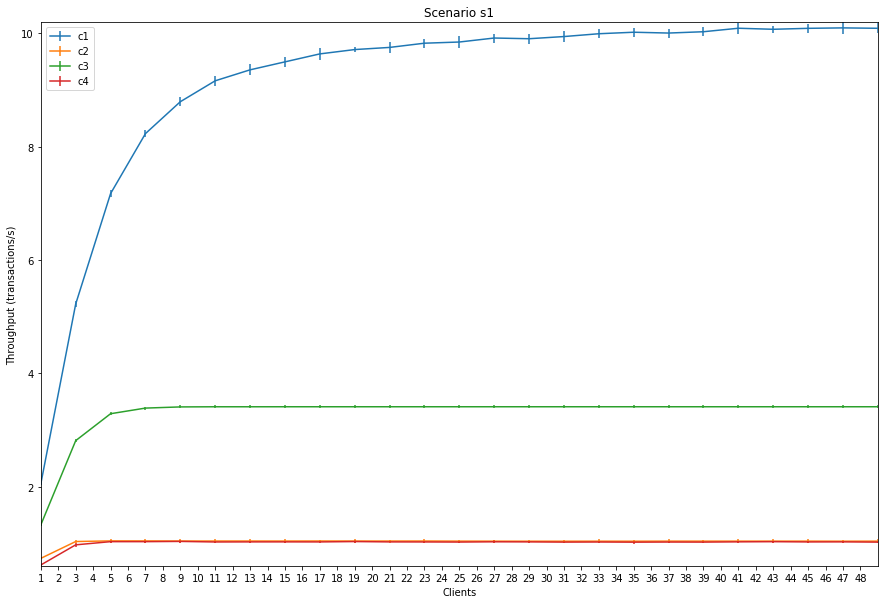

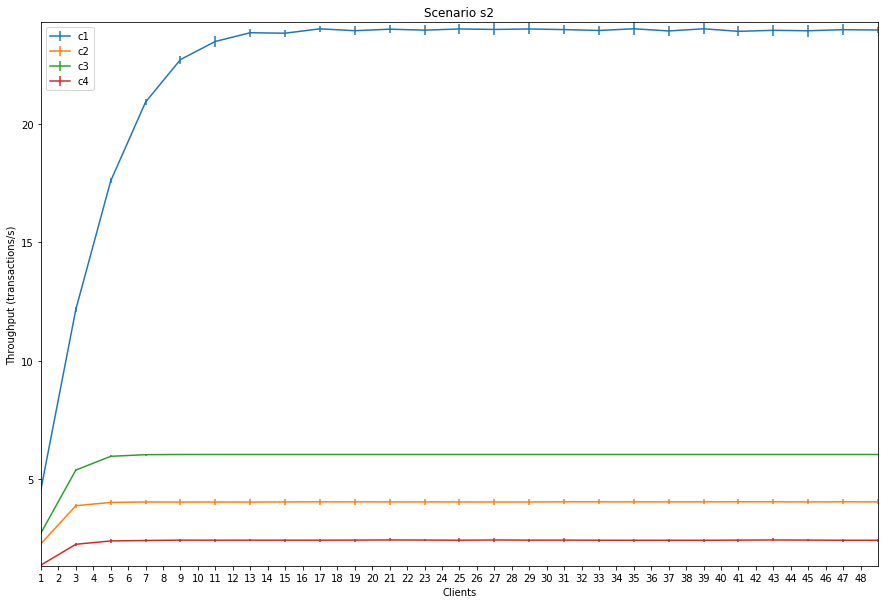

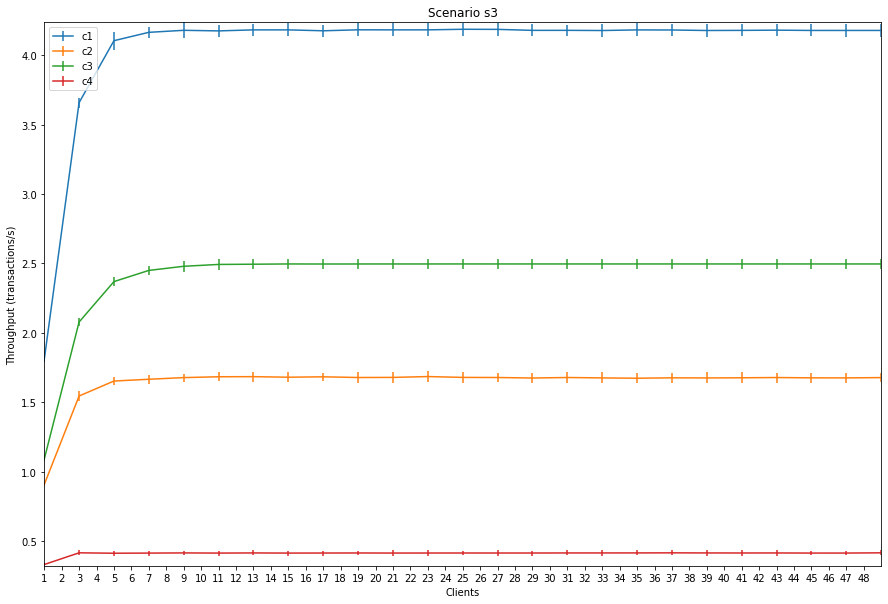

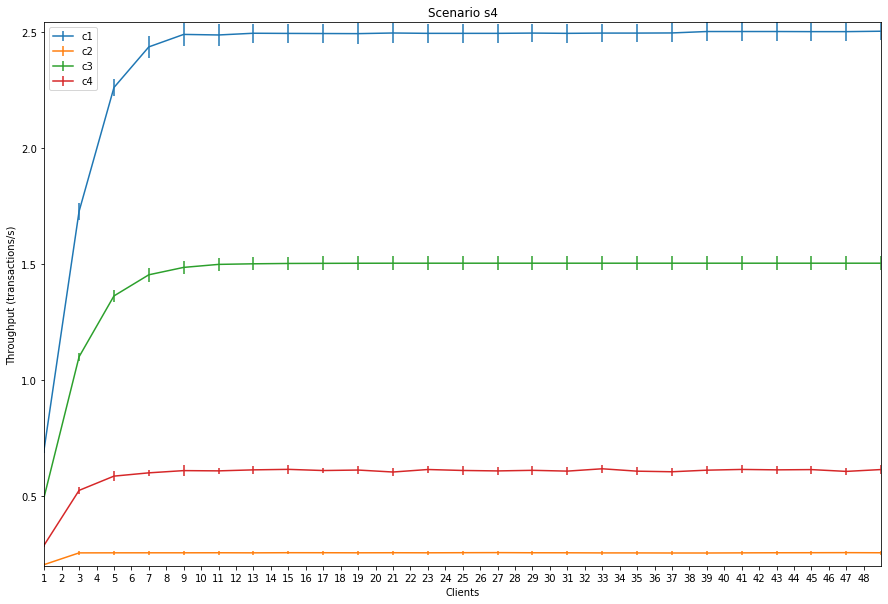

In [149]:
#FOR EVERY SCENARIO AND EVERY CONFIGURATIONS SHOW HOW CHANGE THE THROUGHPUT TIME WITH DIFFERENT NUMBER OF CLIENTS

for scenario in scenarios:
    plt.figure(figsize=(15,10))
    plt.title("Scenario "+scenario)
    plt.margins(0)
    plt.xticks(range(dfThroughput['clients'].min(),dfThroughput['clients'].max()))
    markers=["-o","^","+","d","h",]
    for index,conf in enumerate(configurations):
        dfTemp=dfThroughput.loc[(dfThroughput['scenario']== scenario) & (dfThroughput['config'] == conf)]
        plt.errorbar(dfTemp['clients'], dfTemp['throughput_mean'],yerr=dfTemp['throughput_ci'])
    
        
    #LABELLING THE PLOT
    plt.xlabel('Clients') 
    plt.ylabel('Throughput (transactions/s)')
    #plt.legend(configurations)
    plt.legend(['c1','c2','c3','c4'])
    plt.show()



In [160]:
#RENSPONSE TIME

#QUERY DB
dfResponseTime=pd.read_sql_query("""
SELECT clients, scenario, config,attrValue,statMean as responseTime 
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
WHERE 
		statName = "responseTimeStat:stats" AND
		moduleName = "Network"
        AND attrName = "repetition"
ORDER BY scenario, config, clients, attrValue
""", con)

#Adding column for mean of the sample and the confidence interval
dfResponseTime['responseTime_mean'] = dfResponseTime.groupby(['scenario','config','clients'])['responseTime'].transform('mean')
dfResponseTime['responseTime_ci'] = dfResponseTime.groupby(['scenario','config','clients'])['responseTime'].transform(conf_interval)

dfResponseTime.head()

#dfResponseTime=dfResponseTime.loc[(dfResponseTime['attrValue']== '0')]
#dfResponseTime.drop(['attrValue'],axis=1)


,clients,scenario,config,attrValue,responseTime,responseTime_mean,responseTime_ci
0,1,s1,c1,0,0.480001,0.487371,0.00579
1,1,s1,c1,1,0.496964,0.487371,0.00579
2,1,s1,c1,2,0.486095,0.487371,0.00579
3,1,s1,c1,3,0.481619,0.487371,0.00579
4,1,s1,c1,4,0.489958,0.487371,0.00579


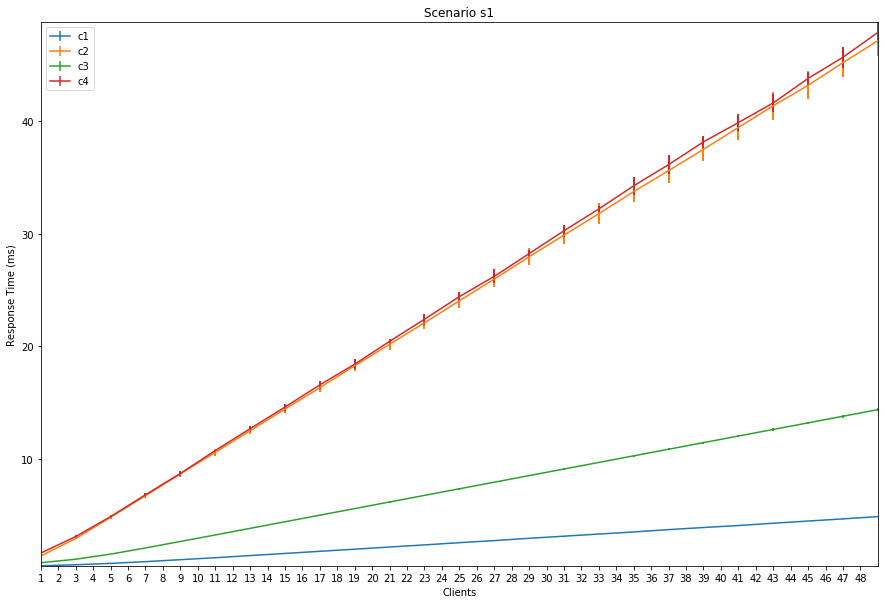

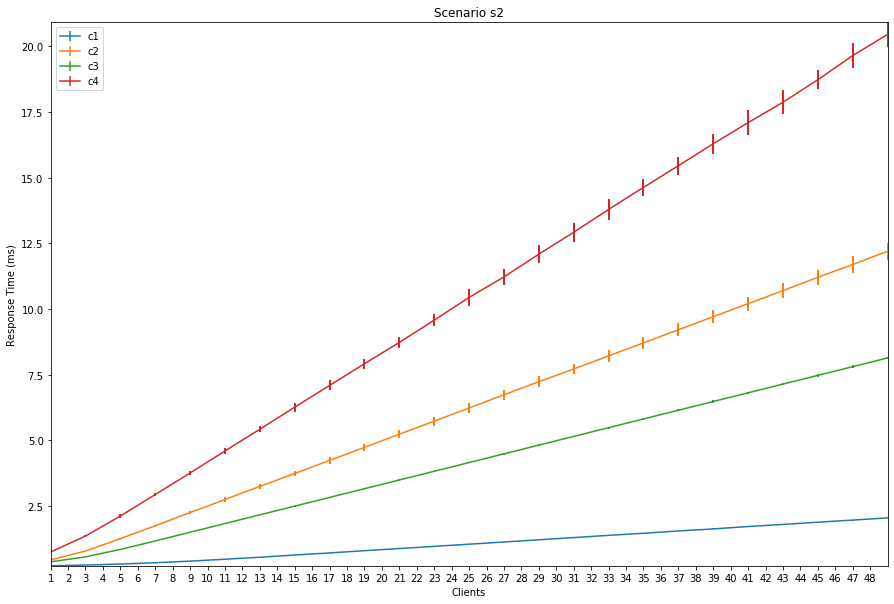

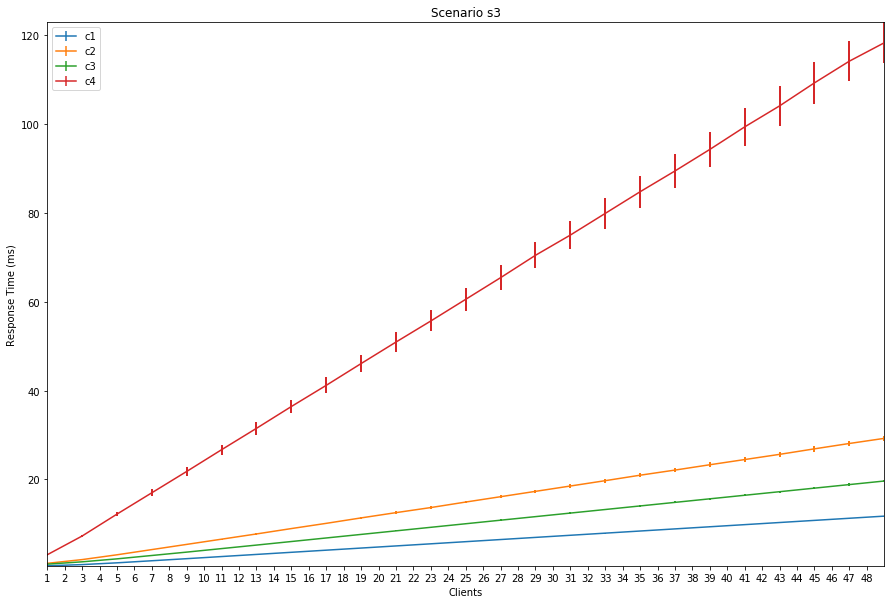

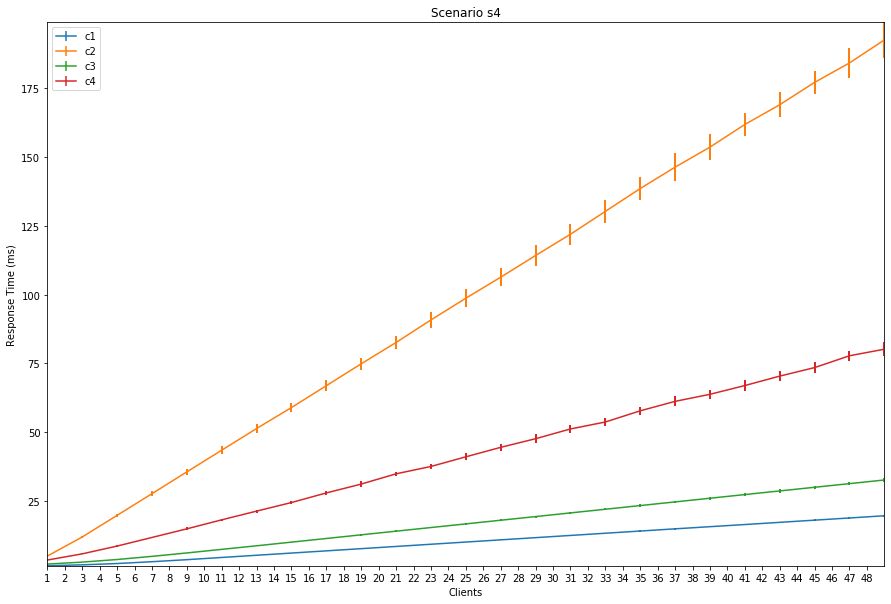

In [161]:


#FOR EVERY SCENARIO AND EVERY CONFIGURATIONS SHOW HOW CHANGE THE RESPONSE TIME WITH DIFFERENT NUMBER OF CLIENTS
for scenario in scenarios:
    plt.figure(figsize=(15,10))
    plt.title("Scenario "+scenario)
    plt.margins(0)
    plt.xticks(range(dfResponseTime['clients'].min(),dfResponseTime['clients'].max()))
    for conf in configurations:
        dfTemp=dfResponseTime.loc[(dfResponseTime['scenario']== scenario) & (dfResponseTime['config'] == conf)]
        plt.errorbar(dfTemp['clients'], dfTemp['responseTime_mean'],yerr=dfTemp['responseTime_ci'])
    
    #LABELLING THE PLOT
    
    plt.xlabel('Clients') 
    plt.ylabel('Response Time (ms)')
    #plt.legend(configurations)
    plt.legend(['c1','c2','c3','c4'])
    plt.show()




In [195]:
#COMPONENTS UTILIZATION GROUPED BY SCENARIOS WITH FINAL CONFIGURATIONS

#QUERY DB
dfUtilization=pd.read_sql_query("""
SELECT clients, scenario, config, moduleName,attrValue, statSum/4800 as utilization 
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
WHERE
		statName = "workingStat:stats"
        AND attrName = "repetition"
        AND clients=49
ORDER BY scenario,config,clients,moduleName
""", con)


#Prendo solo le configurazioni rilevanti

dfUtilization=dfUtilization.loc[(dfUtilization.config=="c1") | (dfUtilization.config=="c3")|(dfUtilization.config=="c5")|(dfUtilization.config=="c8")]

#Rimappo i nomi nel dataframe con un dizionario
configDictionary={"c1": "c1","c3": "c2","c5": "c3","c8": "c4"}
dfUtilization["config"]=dfUtilization["config"].map(configDictionary)


#Adding column for mean of the sample and the confidence interval
dfUtilization['utilization_mean'] = dfUtilization.groupby(['scenario','config','clients','moduleName'])['utilization'].transform('mean')
dfUtilization['utilization_ci'] = dfUtilization.groupby(['scenario','config','clients','moduleName'])['utilization'].transform(conf_interval)


dfUtilization=dfUtilization.loc[(dfUtilization['attrValue']== '0')]
dfUtilization=dfUtilization.drop(['attrValue'],axis=1)

#Set here number of clients 
clientsNum=49

dfUtilization

,clients,scenario,config,moduleName,utilization,utilization_mean,utilization_ci
0,49,s1,c1,Network.remote_server,0.751466,0.750511,0.028053
10,49,s1,c1,Network.server.disk,0.831330,0.771687,0.028382
20,49,s1,c1,Network.server.processor,0.222598,0.222504,0.001030
66,49,s1,c2,Network.remote_server,0.999957,0.999964,0.000008
76,49,s1,c2,Network.server.disk,0.076984,0.075869,0.003153
86,49,s1,c2,Network.server.processor,0.023362,0.022863,0.000561
120,49,s1,c3,Network.remote_server,0.242279,0.245645,0.003336
130,49,s1,c3,Network.server.disk,0.249928,0.247318,0.003396
140,49,s1,c3,Network.server.processor,0.999991,0.999991,0.000000
214,49,s1,c4,Network.remote_server,0.070921,0.074875,0.002914


0      0.028053
10     0.028382
20     0.001030
66     0.000008
76     0.003153
86     0.000561
120    0.003336
130    0.003396
140    0.000000
214    0.002914
224    0.000150
234    0.004141
Name: utilization_ci, dtype: float64


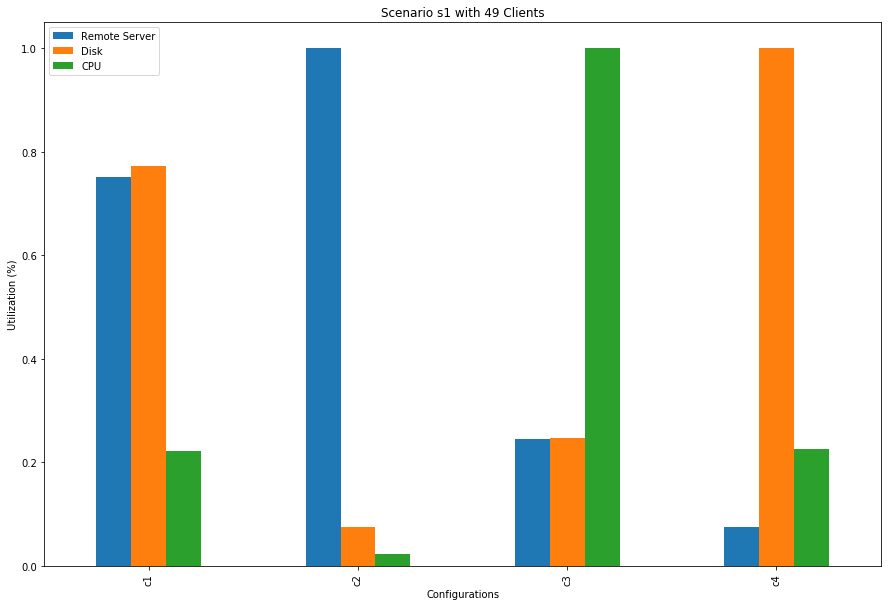

240    0.005939
250    0.000019
260    0.001308
300    0.000009
310    0.004569
320    0.001108
360    0.001665
370    0.004143
380    0.000000
454    0.001515
464    0.000144
474    0.005422
Name: utilization_ci, dtype: float64


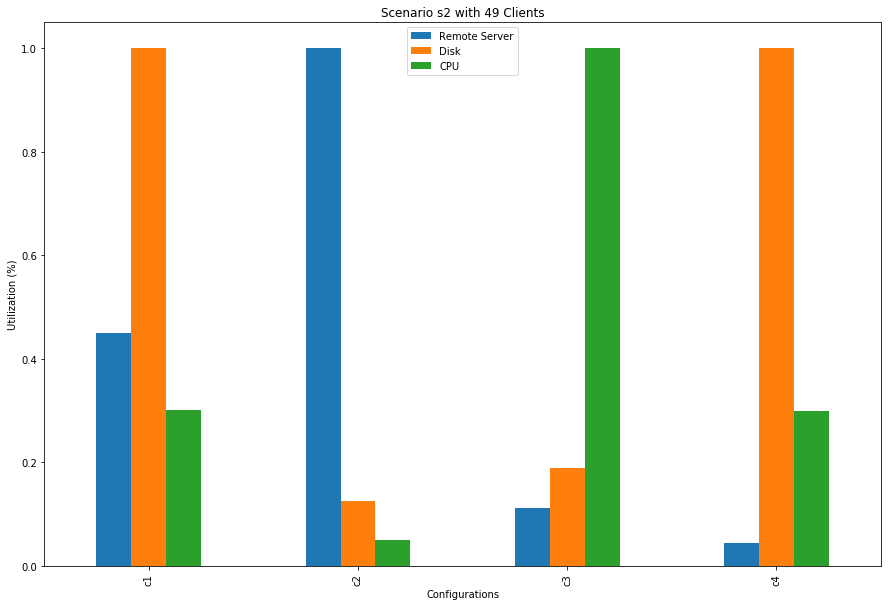

480    0.002702
490    0.000006
500    0.000847
540    0.000006
550    0.006431
560    0.000864
600    0.002707
610    0.003614
620    0.000000
690    0.001448
700    0.000066
710    0.003531
Name: utilization_ci, dtype: float64


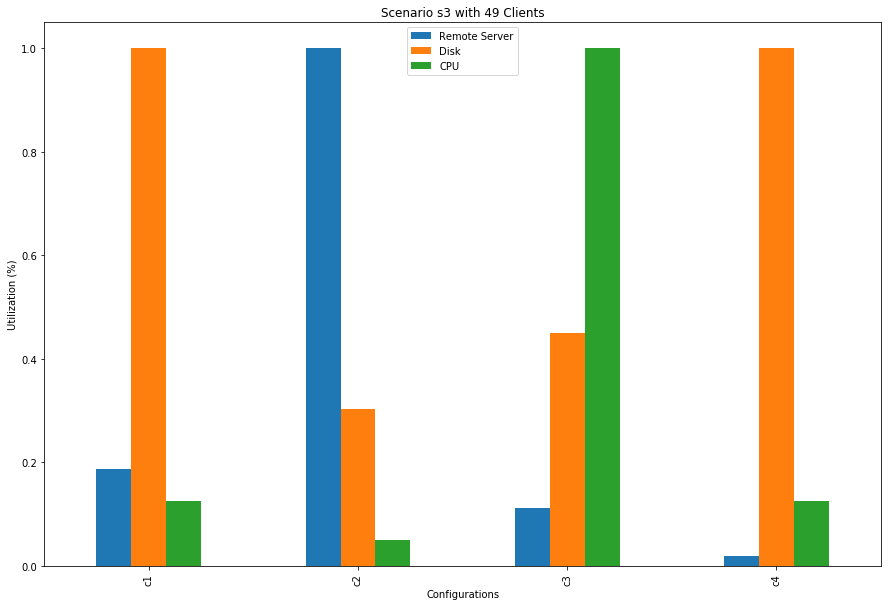

720    0.000006
730    0.006281
740    0.000978
780    0.000003
790    0.001704
800    0.000203
840    0.004686
850    0.002909
860    0.000000
933    0.003819
943    0.000105
953    0.007173
Name: utilization_ci, dtype: float64


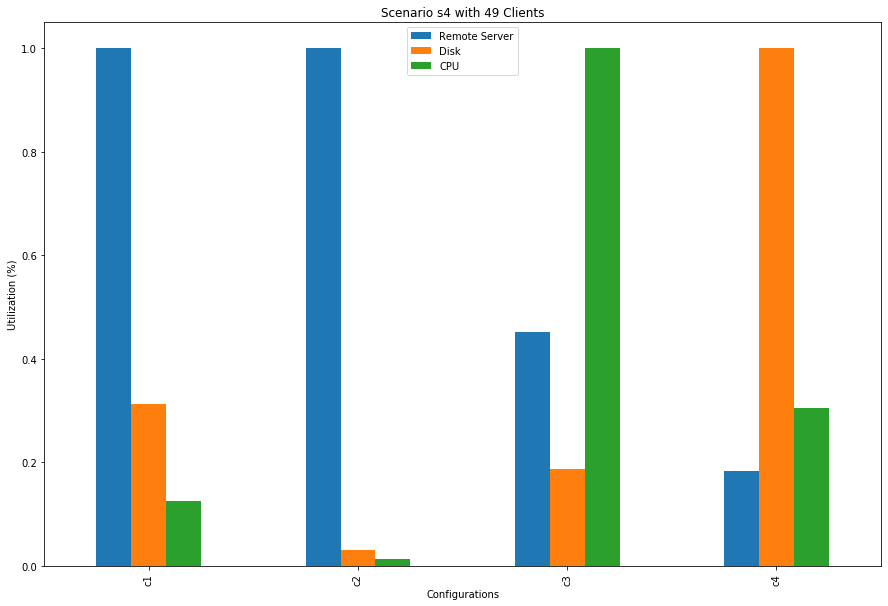

In [201]:
#For every configurations plot a graph of utilization of the components by every scenario

for scenario in scenarios:

    dfTemp=dfUtilization.loc[(dfUtilization['clients']== clientsNum)&(dfUtilization['scenario']== scenario)]
    plot=dfTemp.groupby(['config', 'moduleName'])['utilization_mean'].mean().unstack().plot.bar(yerr=dfTemp['utilization_ci'],figsize=(15,10))
    plt.title('Scenario '+scenario+' with '+str(clientsNum)+' Clients')
    print(dfTemp['utilization_ci'])
    
    #LABELLING THE PLOT

    plt.xlabel('Configurations') 
    plt.ylabel('Utilization (%)')
    plt.legend(['Remote Server',"Disk","CPU"])
    plt.show()

# Simulation Results

In [5]:
#THROUGHPUT

dfThroughput=pd.read_sql_query("""
SELECT clients, scenario, config, AVG(statCount) / 3600.0 as throughput 
FROM runConfig NATURAL JOIN statistic
WHERE statName = "completedTransactions:stats" 
GROUP BY scenario,config, clients, moduleName
ORDER BY clients
""", con)

#Getting all the configurations in the simulation table (column config)
#configurations=dfThroughput['config'].unique()
configurations=['c1','c3','c5','c8']

#Getting all the scenarios in the simulation table (column config)
scenarios=dfThroughput['scenario'].unique()


#Test
print(configurations)

print(dfThroughput)

print(dfThroughput['throughput'].max())

['c1', 'c3', 'c5', 'c8']
     clients scenario config  throughput
0          1       s1     c1    2.052250
1          1       s1     c2    0.455556
2          1       s1     c3    0.735722
3          1       s1     c4    0.735583
4          1       s1     c5    1.326833
..       ...      ...    ...         ...
795       49       s4     c4    0.592472
796       49       s4     c5    1.503389
797       49       s4     c6    0.254250
798       49       s4     c7    0.253389
799       49       s4     c8    0.613361

[800 rows x 4 columns]
24.04675


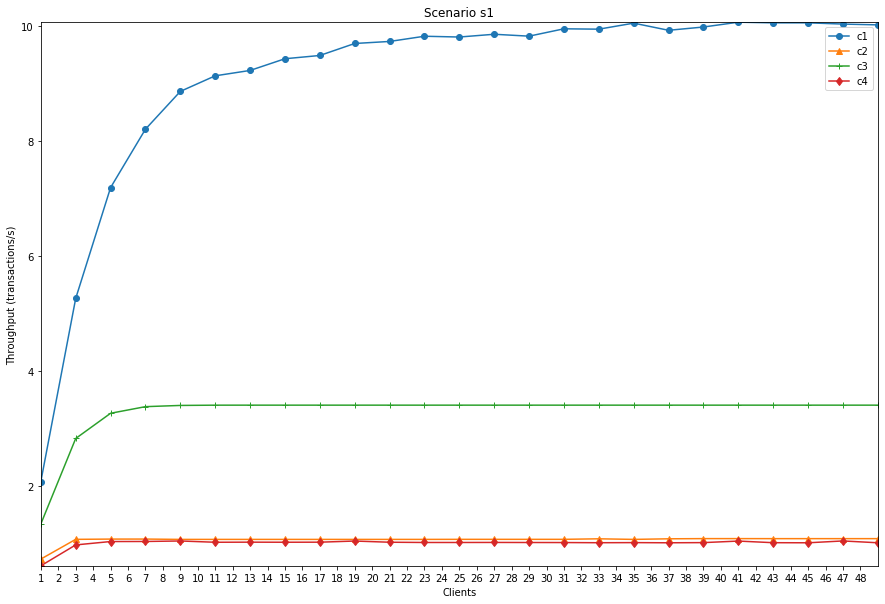

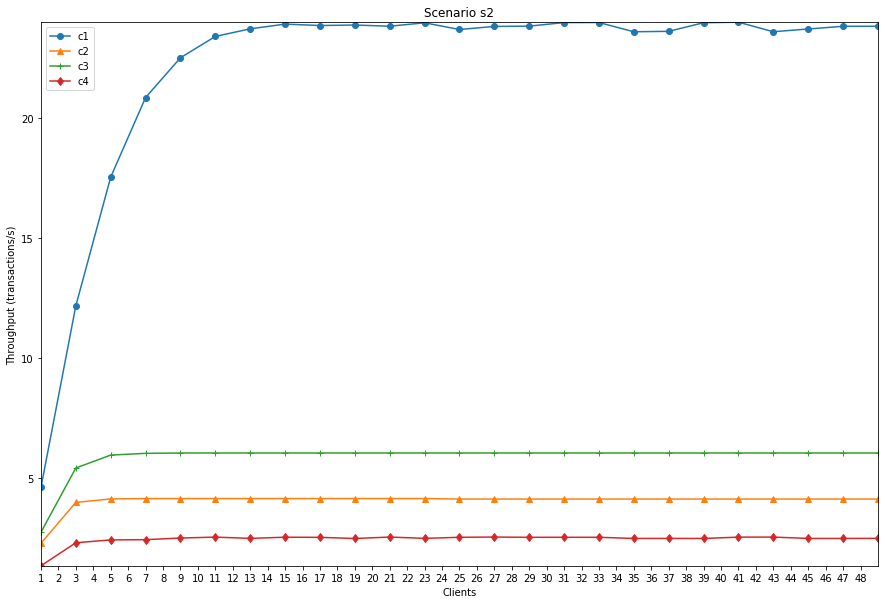

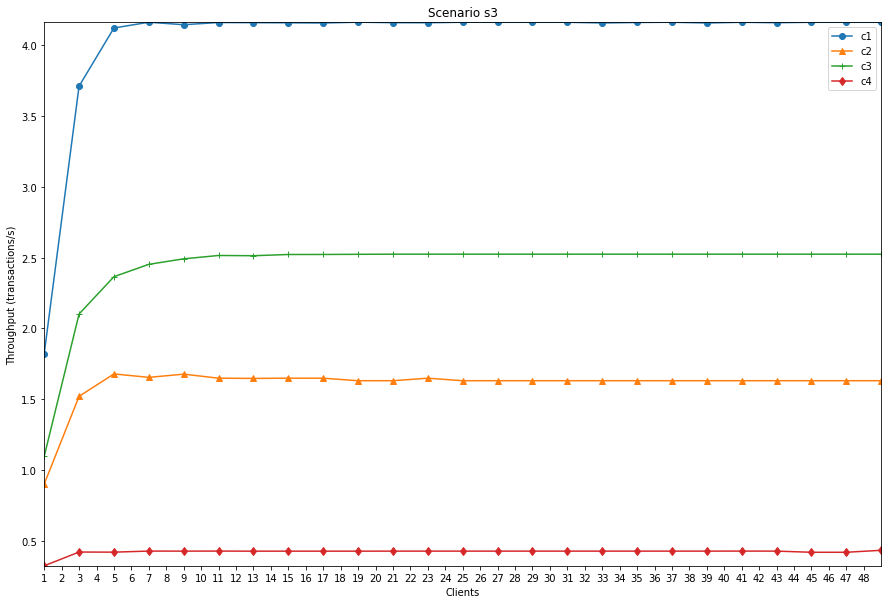

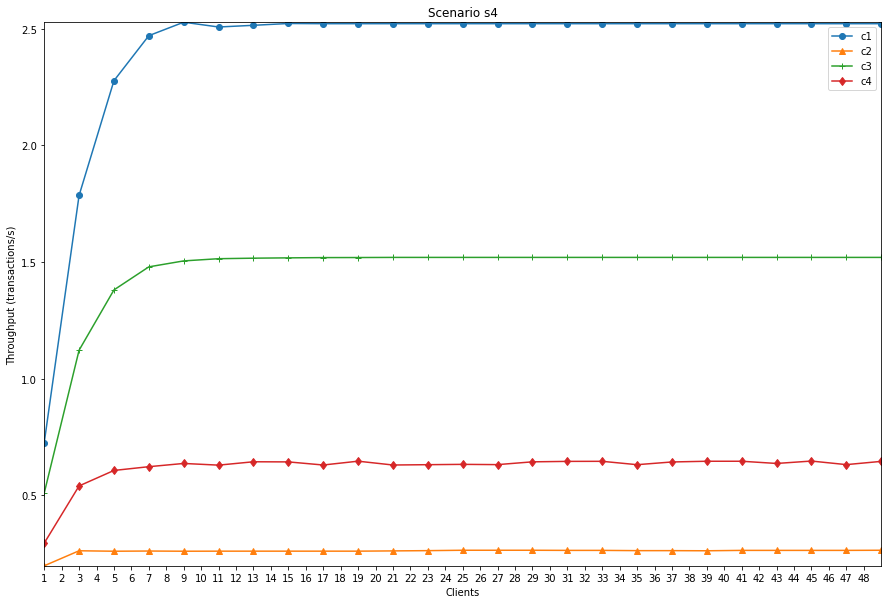

In [169]:
#FOR EVERY SCENARIO AND EVERY CONFIGURATIONS SHOW HOW CHANGE THE THROUGHPUT TIME WITH DIFFERENT NUMBER OF CLIENTS

for scenario in scenarios:
    plt.figure(figsize=(15,10))
    plt.title("Scenario "+scenario)
    plt.margins(0)
    plt.xticks(range(dfThroughput['clients'].min(),dfThroughput['clients'].max()))
    markers=["-o","-^","-+","-d","-h"]
    for index,conf in enumerate(configurations):
        dfTemp=dfThroughput.loc[(dfThroughput['scenario']== scenario) & (dfThroughput['config'] == conf)]
        plt.plot(dfTemp['clients'], dfTemp['throughput'],markers[index%len(markers)])
        #Plot error bar
        
    #LABELLING THE PLOT
    plt.xlabel('Clients') 
    plt.ylabel('Throughput (transactions/s)')
    #plt.legend(configurations)
    plt.legend(['c1','c2','c3','c4'])
    plt.show()



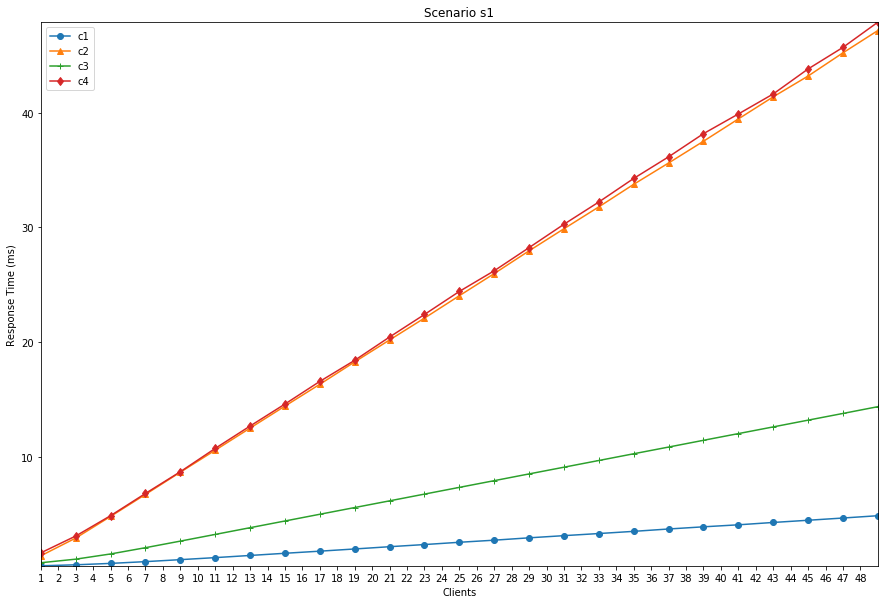

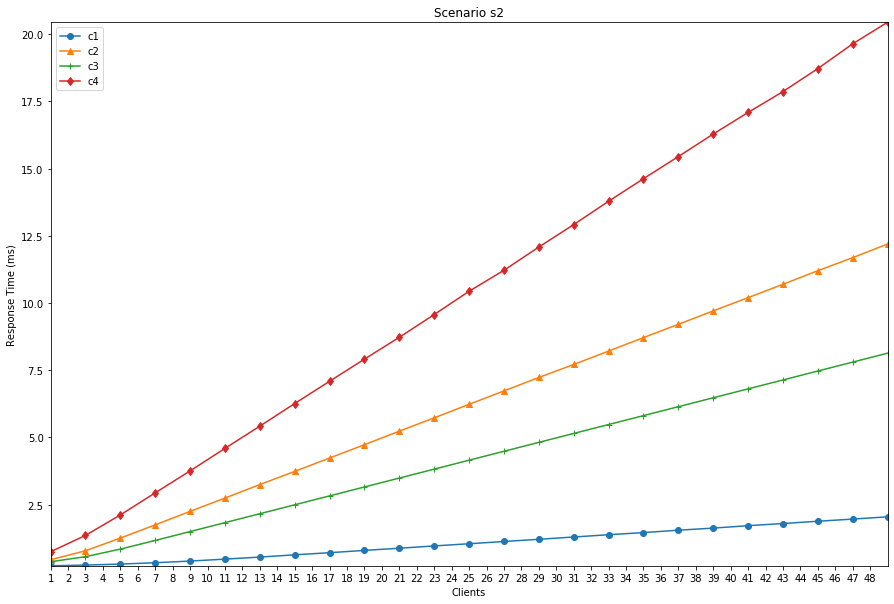

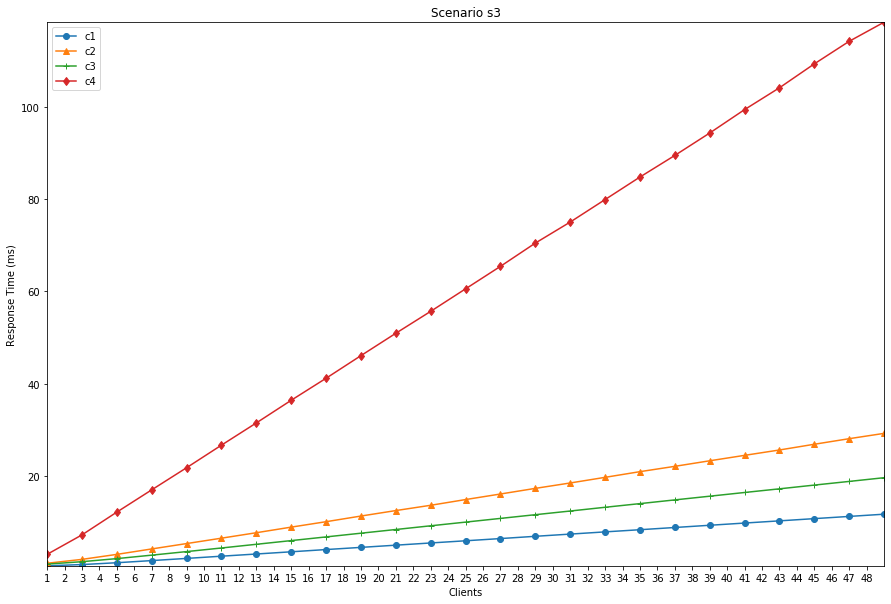

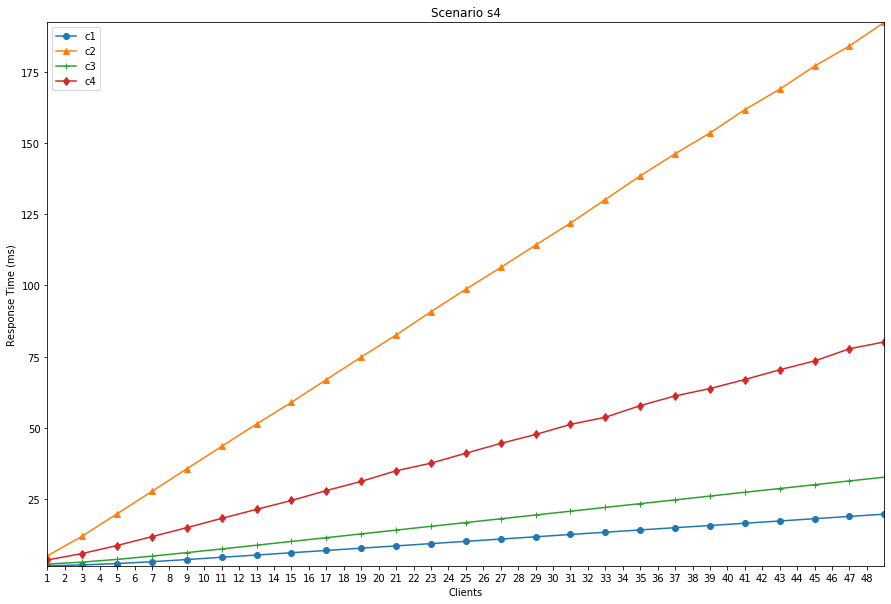

In [168]:
#RENSPONSE TIME

#QUERY DB
dfResponseTime=pd.read_sql_query("""
SELECT clients, scenario, config,AVG(statMean) as responseTime 
FROM runConfig NATURAL JOIN statistic
WHERE 
		statName = "responseTimeStat:stats" AND
		moduleName = "Network"
GROUP BY scenario,config, clients
ORDER BY clients
""", con)

#FOR EVERY SCENARIO AND EVERY CONFIGURATIONS SHOW HOW CHANGE THE RESPONSE TIME WITH DIFFERENT NUMBER OF CLIENTS
for scenario in scenarios:
    plt.figure(figsize=(15,10))
    plt.title("Scenario "+scenario)
    plt.margins(0)
    plt.xticks(range(dfResponseTime['clients'].min(),dfResponseTime['clients'].max()))
    markers=["-o","-^","-+","-d","-h",]
    for index,conf in enumerate(configurations):
        dfTemp=dfResponseTime.loc[(dfResponseTime['scenario']== scenario) & (dfResponseTime['config'] == conf)]
        plt.plot(dfTemp['clients'], dfTemp['responseTime'],markers[index%len(markers)])
    
    #LABELLING THE PLOT
    
    plt.xlabel('Clients') 
    plt.ylabel('Response Time (ms)')
    #plt.legend(configurations)
    plt.legend(['c1','c2','c3','c4'])
    plt.show()





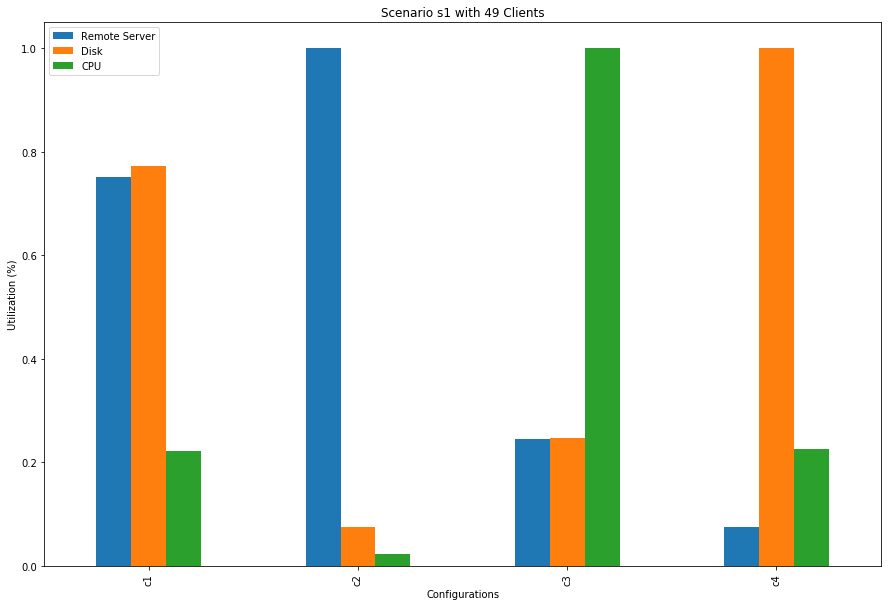

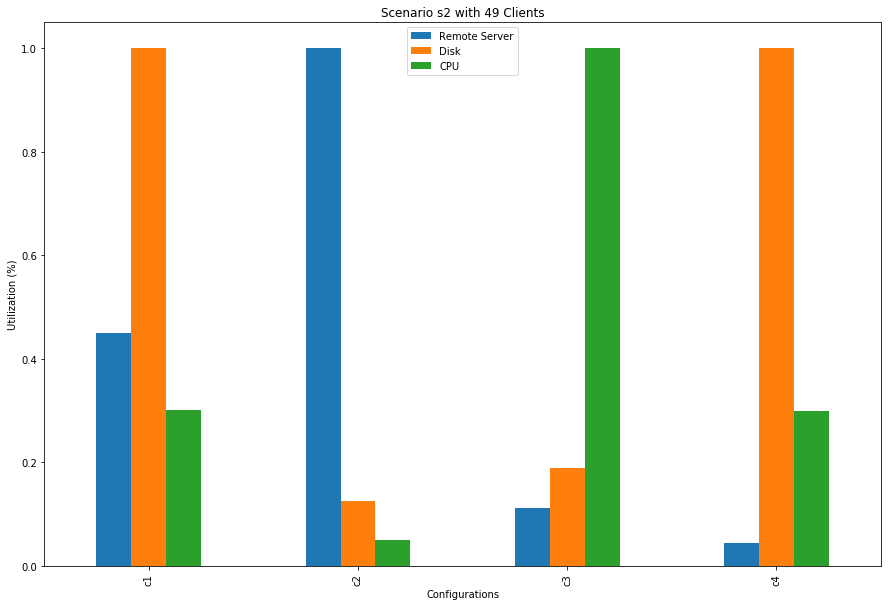

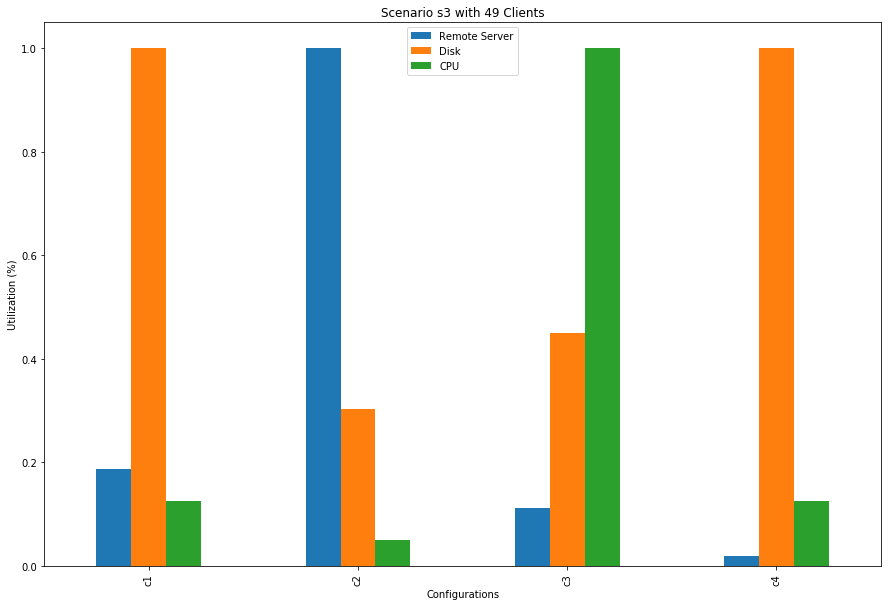

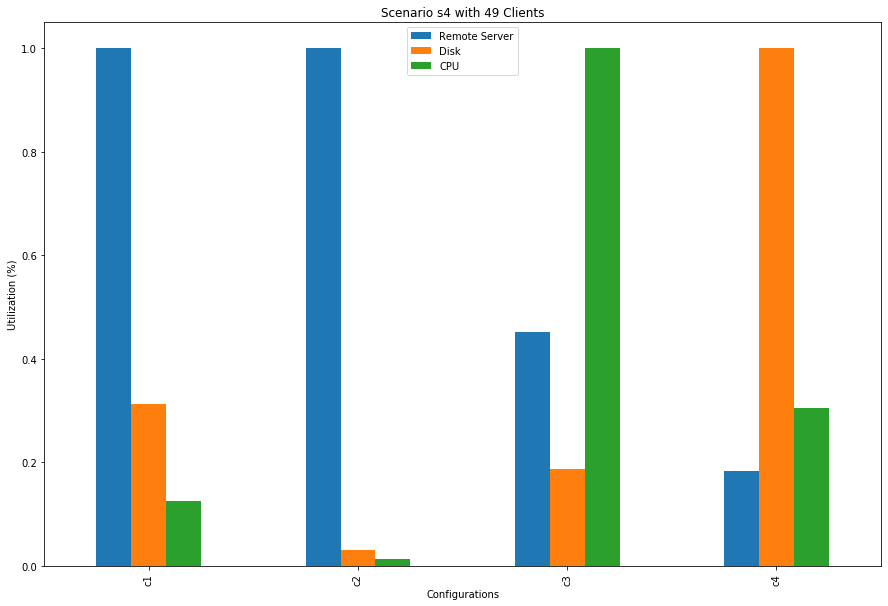

In [87]:
#COMPONENTS UTILIZATION GROUPED BY SCENARIOS WITH FINAL CONFIGURATIONS

#QUERY DB
dfUtilization=pd.read_sql_query("""
SELECT clients, scenario, config, moduleName, AVG(statSum)/4800 as utilization 
FROM runConfig NATURAL JOIN statistic
WHERE
		statName = "workingStat:stats"
GROUP BY scenario,config, clients, moduleName
ORDER BY clients
""", con)


#Prendo solo le configurazioni rilevanti

dfUtilization=dfUtilization.loc[(dfUtilization.config=="c1") | (dfUtilization.config=="c3")|(dfUtilization.config=="c5")|(dfUtilization.config=="c8")]

#Rimappo i nomi nel dataframe con un dizionario
configDictionary={"c1": "c1","c3": "c2","c5": "c3","c8": "c4"}
dfUtilization["config"]=dfUtilization["config"].map(configDictionary)

#Set here number of clients 
clientsNum=49

#For every configurations plot a graph of utilization of the components by every scenario

for scenario in scenarios:

    dfTemp=dfUtilization.loc[(dfUtilization['clients']== clientsNum)&(dfUtilization['scenario']== scenario)]

    plot=dfTemp.groupby(['config', 'moduleName'])['utilization'].mean().unstack().plot.bar(figsize=(15,10))
    plt.title('Scenario '+scenario+' with '+str(clientsNum)+' Clients')
    
    #LABELLING THE PLOT

    plt.xlabel('Configurations') 
    plt.ylabel('Utilization (%)')
    plt.legend(['Remote Server',"Disk","CPU"])
    plt.show()

In [7]:
con.close()